In [50]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

plt.style.use('dark_background')

In [51]:
def derivative(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]

In [52]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,1),
        )
        
    def forward(self, x):
        """
        input: x = [t, x]
        output: u(t, x)
        """
        return self.model(x)

In [53]:
EPOCHS = 15000
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
MSE_LOSS = nn.MSELoss()
LR = 1e-3
WEIGHT_DECAY = 1e-5
TIMEFRAME = 2

In [54]:
model = PINN().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

A solution $u$ is considered correct if ${\displaystyle {\frac {\partial u}{\partial t}}=\alpha \left({\frac {\partial ^{2}u}{\partial x^{2}}}\right)}$

In [55]:
num_pde_points = 10000

def PDE_loss():
    x = (torch.rand(num_pde_points, 1, requires_grad=True)).to(DEVICE)
    t = (torch.rand(num_pde_points, 1, requires_grad=True)*TIMEFRAME).to(DEVICE)
    points = torch.cat([t, x], dim=1).to(DEVICE)

    u = model(points)
    
    alpha = 0.8 # thermal diffusivity of iron mm^2/s
    u_t = derivative(u, t)
    u_x = derivative(u, x)
    u_xx = derivative(u_x, x)
    
    
    mse = MSE_LOSS(u_t, alpha*u_xx)
    
    return mse

In [56]:
num_boundary_conditions = 25 # boundary condition points per side
num_initial_conditions = 50 # initial condition points per value (positive and negative step function)

top_boundary_points = torch.cat([torch.linspace(0, TIMEFRAME, num_boundary_conditions).reshape(-1, 1), torch.zeros(num_boundary_conditions).reshape(-1, 1)], dim=1)
top_boundary_points_values = torch.ones(num_boundary_conditions)*10

bottom_boundary_points = torch.cat([torch.linspace(0, TIMEFRAME, num_boundary_conditions).reshape(-1, 1), torch.ones(num_boundary_conditions).reshape(-1, 1)], dim=1)
bottom_boundary_points_values = torch.ones(num_boundary_conditions)*-10

all_boundary_points = torch.cat([top_boundary_points, bottom_boundary_points], dim=0)
all_boundary_points_values = torch.cat([top_boundary_points_values, bottom_boundary_points_values], dim=0)

# step function initial condition

positive_initial_condition = torch.cat([torch.zeros(num_initial_conditions).reshape(-1, 1), torch.linspace(0, 0.5, num_initial_conditions).reshape(-1, 1)], dim=1)
positive_initial_condition_values = 10*torch.ones(num_initial_conditions)

negative_initial_condition = torch.cat([torch.zeros(num_initial_conditions).reshape(-1, 1), torch.linspace(1, 0.5, num_initial_conditions).reshape(-1, 1)], dim=1)
negative_initial_condition_values = -10*torch.ones(num_initial_conditions)

all_initial_condition_points = torch.cat([positive_initial_condition, negative_initial_condition], dim=0)
all_initial_condition_values = torch.cat([positive_initial_condition_values, negative_initial_condition_values], dim=0)

# gaussian initial condition

"""mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, num_initial_conditions)

all_initial_condition_values = torch.from_numpy(stats.norm.pdf(x, mu, sigma)*50).reshape(-1)
all_initial_condition_points_x = torch.from_numpy(np.linspace(0,1,num_initial_conditions)).reshape(-1, 1)
all_initial_condition_points = torch.cat([torch.zeros(num_initial_conditions).reshape(-1, 1), all_initial_condition_points_x], dim=1)"""

all_points = torch.cat([all_initial_condition_points, all_boundary_points], dim=0).to(DEVICE).to(torch.float32)
all_points_values = torch.cat([all_initial_condition_values, all_boundary_points_values], dim=0).to(DEVICE).to(torch.float32)

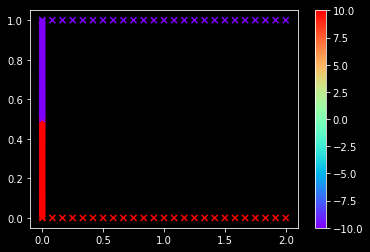

In [57]:
plt.scatter(all_points[:,0].cpu(), all_points[:,1].cpu(), marker='x', c=all_points_values.cpu(), cmap='rainbow')
plt.colorbar()

Epoch: 5000, Loss: 8.338624
1.0019842386245728 7.336639404296875


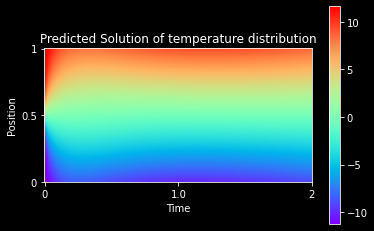

Epoch: 10000, Loss: 5.387255
0.3257600665092468 5.061495304107666


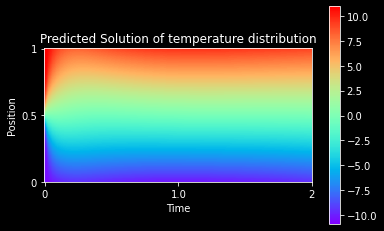

Epoch: 15000, Loss: 7.353316
0.3878615200519562 6.9654541015625


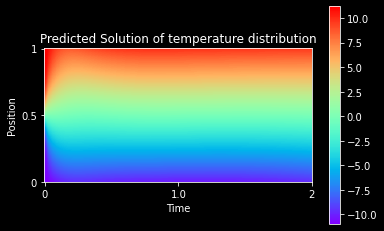

In [58]:
model.train()

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    
    pde_loss = PDE_loss()
    
    ground_truth_loss = MSE_LOSS(all_points_values.view(-1,1).to(torch.float32), model(all_points))
    
    loss = ground_truth_loss + pde_loss
    
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 5000 == 0:
        
        print("Epoch: %d, Loss: %f" % (epoch+1, loss.item()))
        print(pde_loss.item(), ground_truth_loss.item())        
        
        mesh = np.meshgrid(np.linspace(0, TIMEFRAME, 200), np.linspace(0, 1, 100))
        mesh_x, mesh_y = mesh[0], mesh[1]
        mesh = np.array([mesh_x, mesh_y], dtype=np.float32)
        mesh.shape
        plt.imshow(model(torch.from_numpy(mesh).permute(1,2,0).to(DEVICE)).cpu().detach(), cmap='rainbow')
        plt.colorbar()
        _ = plt.title("Predicted Solution of temperature distribution")
        _ = plt.xticks([0, 100, 200], [0, TIMEFRAME/2, TIMEFRAME])
        _ = plt.yticks([0, 50, 100], [1, 0.5, 0])
        _ = plt.xlabel("Time")
        _ = plt.ylabel("Position")
        plt.show()

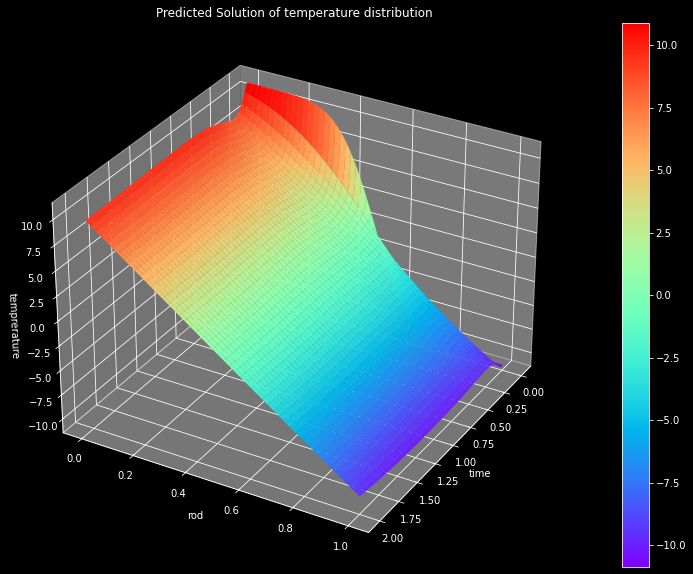

In [59]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

plt.style.use('dark_background')
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')

mesh = np.meshgrid(np.linspace(0, TIMEFRAME, 200), np.linspace(0, 1, 100))
mesh_x, mesh_y = mesh[0], mesh[1]
mesh = np.array([mesh_x, -mesh_y], dtype=np.float32)

input_data = np.stack((mesh_x, mesh_y), axis=-1)
input_data = input_data.reshape(-1, 2)

input_data = torch.from_numpy(input_data).to('cuda')

input_data = input_data.float()
height_data = model(input_data).cpu().detach().numpy()
height_data = height_data.reshape(100, 200)

surf = ax.plot_surface(mesh_x, mesh_y, height_data, cmap='rainbow')

fig.colorbar(surf)

ax.set_title('Predicted Solution of temperature distribution')
ax.set_xlabel('time')
ax.set_ylabel('rod')
ax.set_zlabel('temprerature')

ax.view_init(30, 30)
plt.show()
